In [56]:
# This code was originally writte by Eric Yule in Fall 2023
# It was edited by Jim Kneller in Spring 2024

# The code generates supernova-like density profiles as a function of time 
# according to an analytic prescription. It will save the data, make figures 
# of the density profiles, and stitch them togther into a movie. 

In [59]:
#create the model
import numpy as np
import matplotlib.pyplot as plt

#size of forward shock
def ForwardShockJump(t):
    return 4

#size of reverse shock
def ReverseShockJump(t):
    #reverse shock period 2
    if t >= 2.5:
        return 1 * (t-2.5) + 3.5
    #reverse shock period 1
    elif t <= 1.26:
        return 6/0.46 * (t-0.8) + 1
    elif t >= 1.26 and t < 1.76:
        return -4.5/0.5 * (t-1.26) + 7
    #no backward shock
    elif t >= 1.76:
        return 1

#density behind reverse shock
def WindDensityProfile(r, t):
    if rRS(t) < 0:
        JFS = ForwardShockJump(t)
        N = JFS * ProgenitorDensityProfile(rFS(t))
        return N * ((r/rFS(t))**(-2.3))
    else: 
        N = 11.2
        return 10**N * ((r/1e5)**(-2.0))

#density ahead of forward shock    
def ProgenitorDensityProfile(r):
    return 10e14*((r/1e5)**(-2.6))

#density profile in the between the shocks - just a straight line 
def InterShockDensityProfile(r, t):
    JRS = ReverseShockJump(t)
    JFS = ForwardShockJump(t)
    
    if rRS(t) > 0:
        m = ( JFS * ProgenitorDensityProfile(rFS(t)) - JRS * WindDensityProfile(rRS(t),t) ) / ( rFS(t) - rRS(t) )
        c = JRS * WindDensityProfile(rRS(t),t)
        return m * ( r - rRS(t) ) + c
    else: 
        return WindDensityProfile(r,t)

#position of forward shock
def rFS(t):
    return -8.74e8 + 1.36e9*t

#position of reverse shock
def rRS(t):
    #reverse shock 1 
    if t < 1.75 and t > 0.8:
        return -1.79e9 + 5.54e9*t + -6.67e9*(t**2) + 3.96e9*(t**3) + -9.19e8*(t**4)
    #reverse shock 2 
    elif t >= 2.5:
        return -5.46e7 + -3.64e6*t + 3.14e7*(t**2)
    #tracking the derivative change when there is no reverse shock
    elif t >= 1.75 and t < 2.5:
        if t <= 1.79:
            return -1.11e9*t+2e9
        elif t <= 1.85:
            return 1.7e9*t - 3.03e9
        elif t <= 2.27:
            return 1e8 - 4e7/0.42 * (t-1.85)
        else:
            return 1e7 + 1.2e8 * (t-1.75)
    else:
        return -1


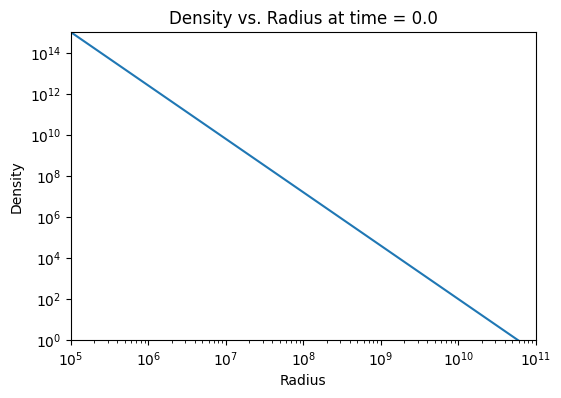

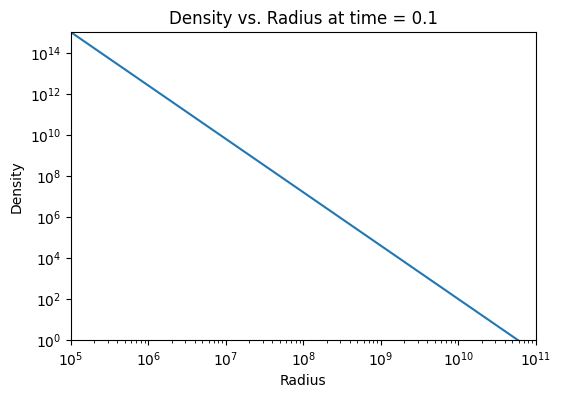

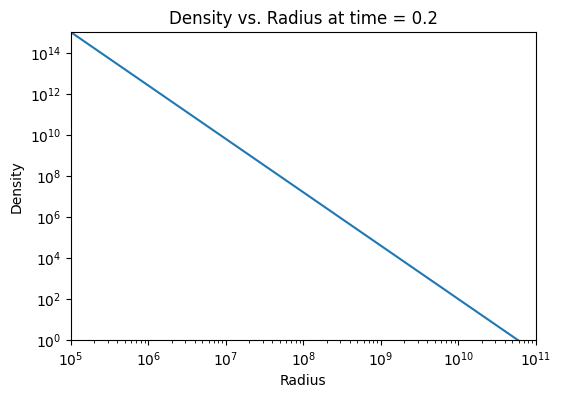

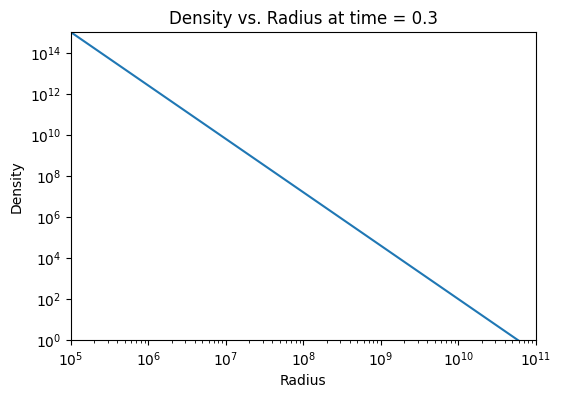

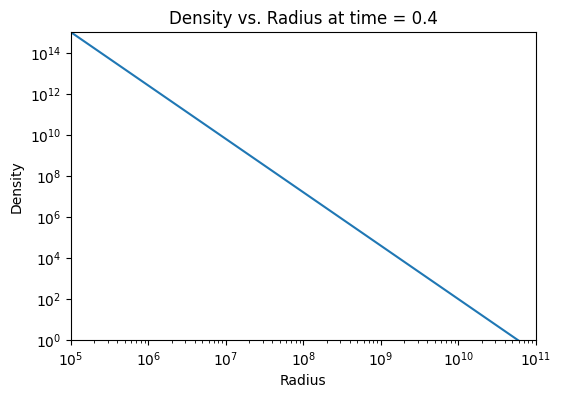

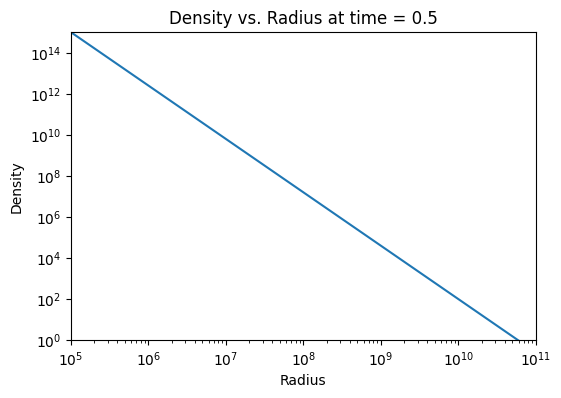

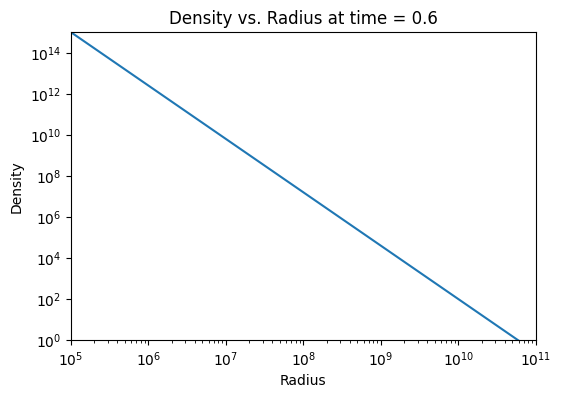

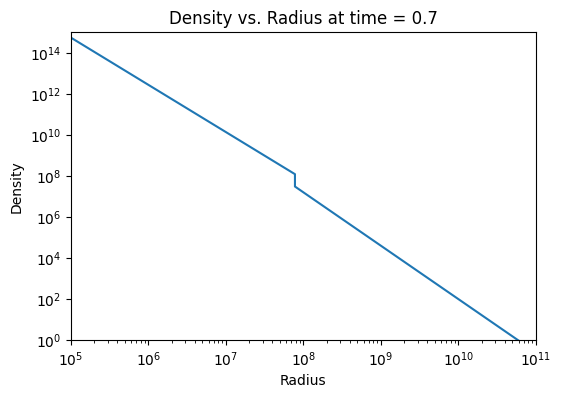

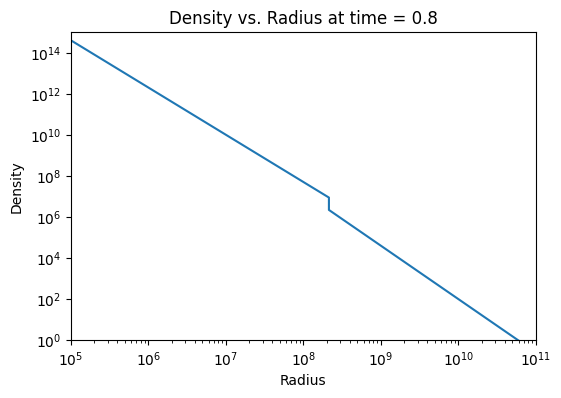

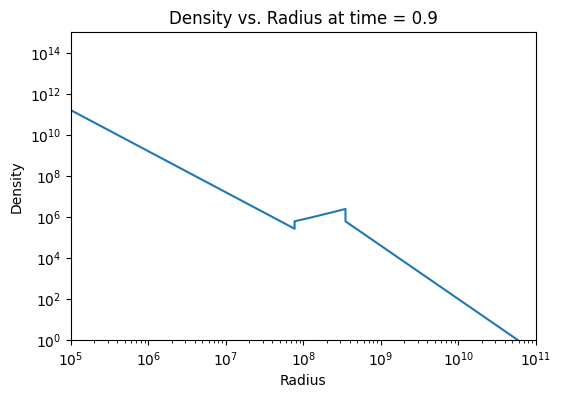

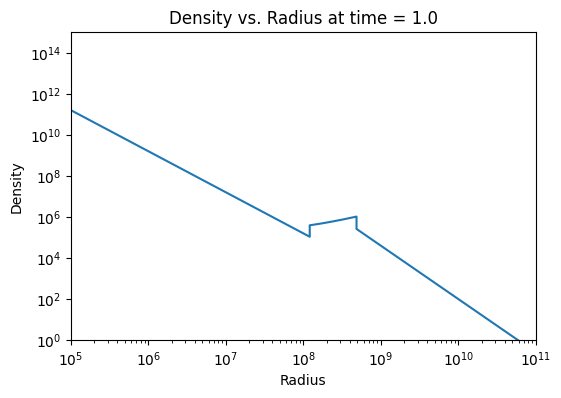

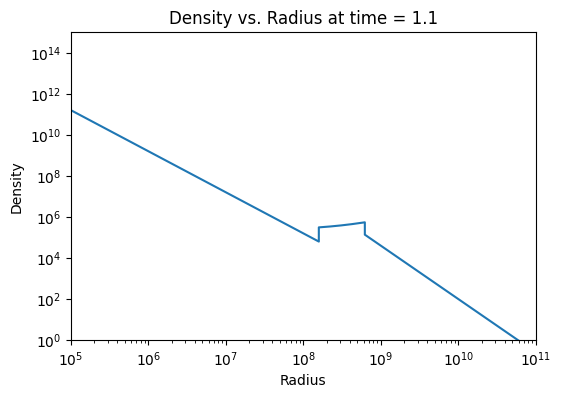

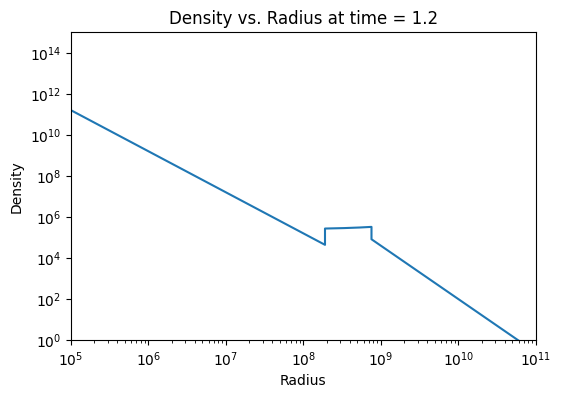

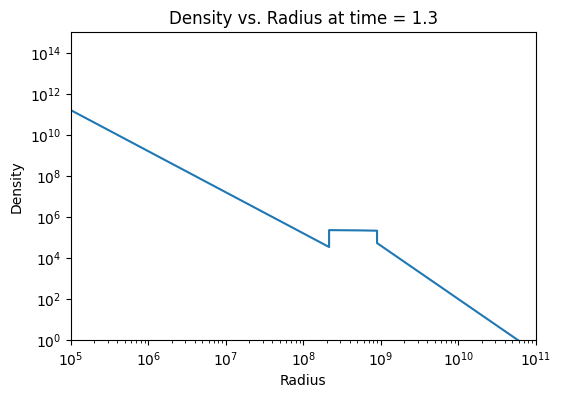

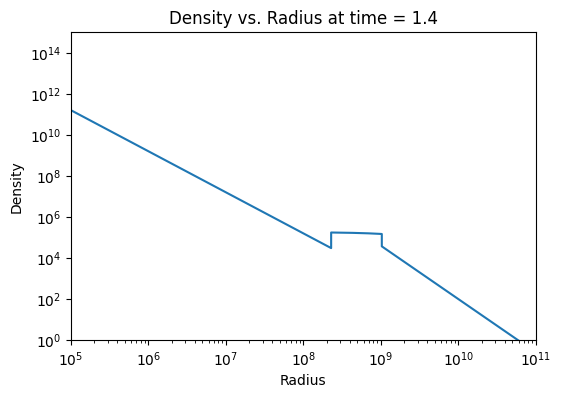

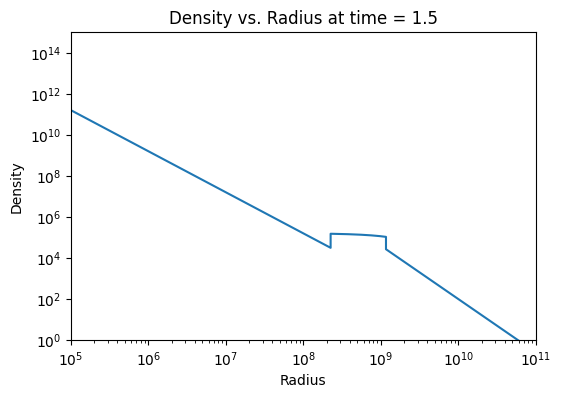

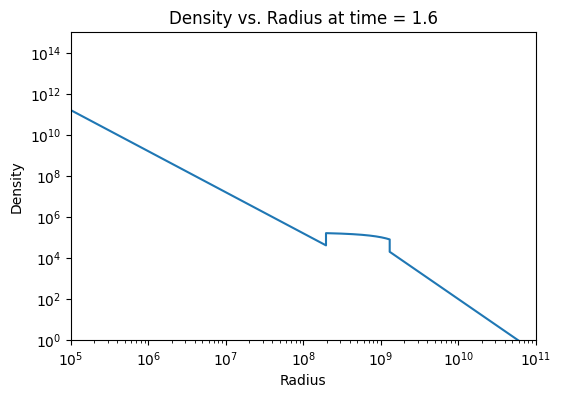

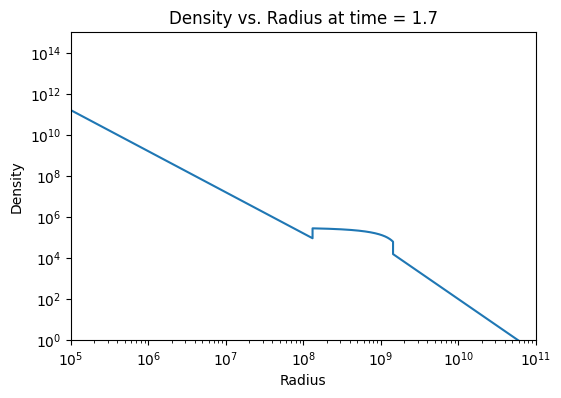

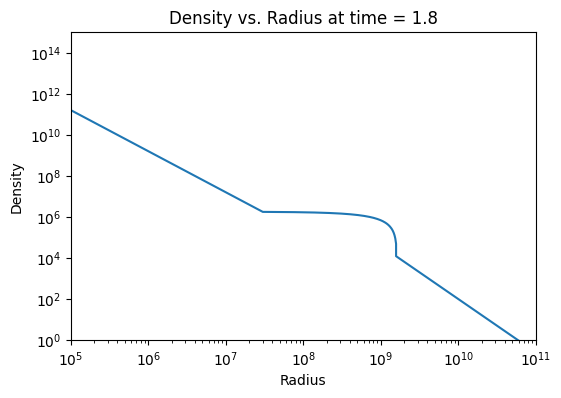

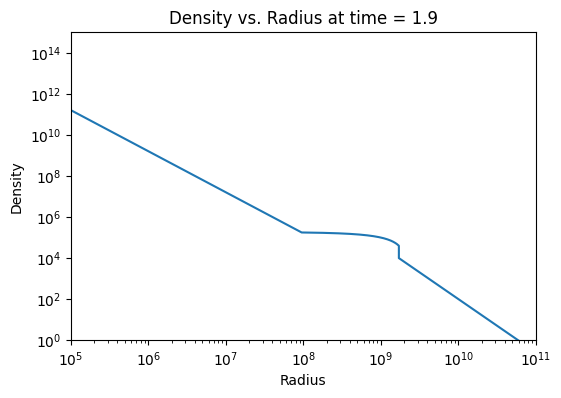

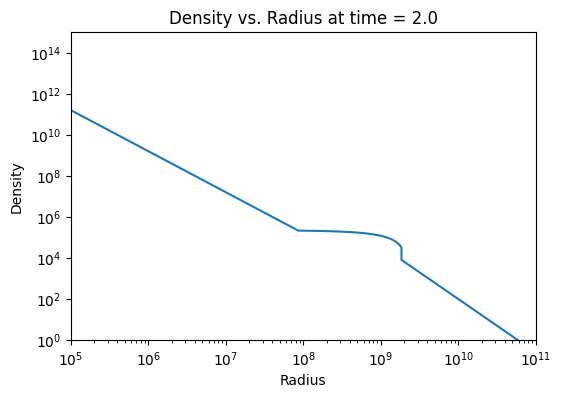

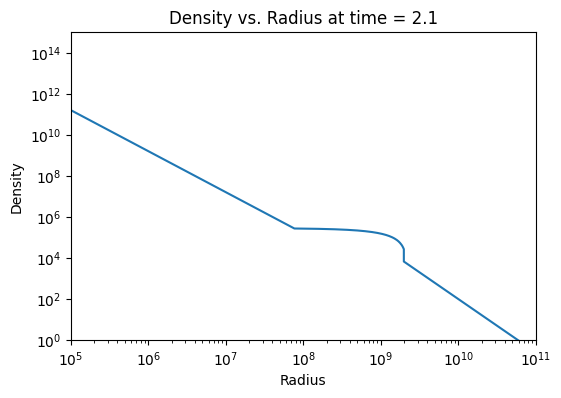

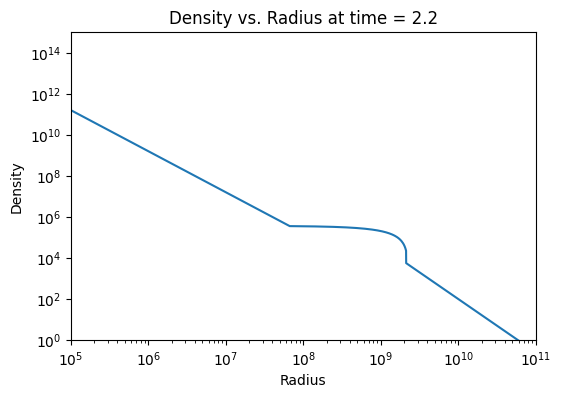

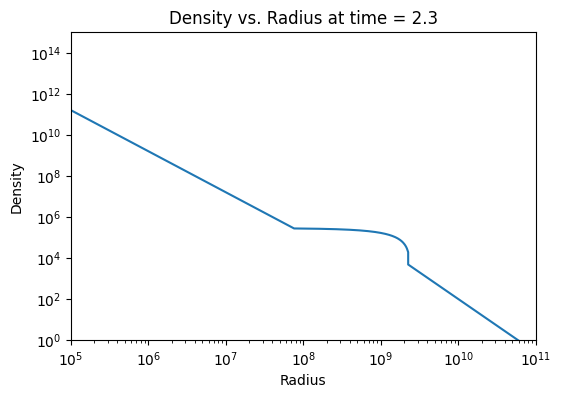

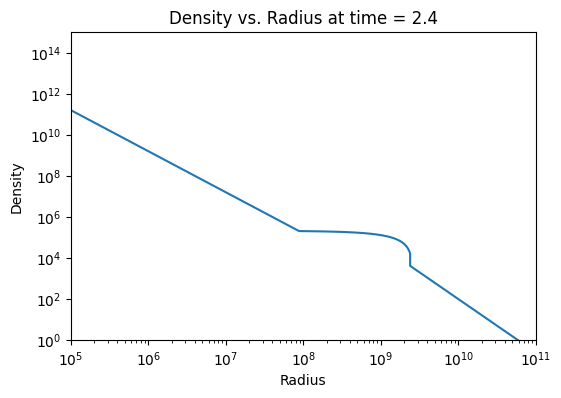

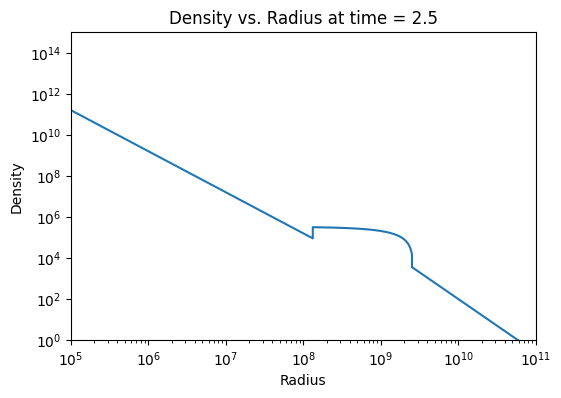

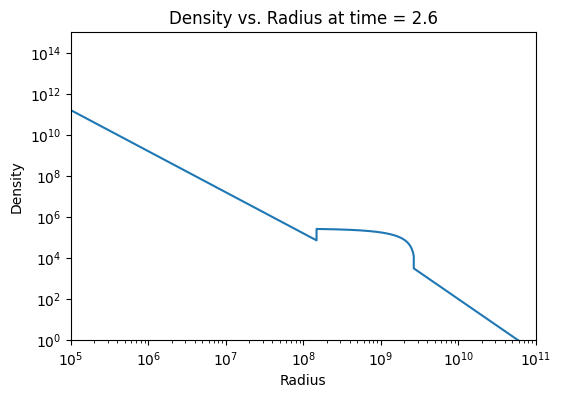

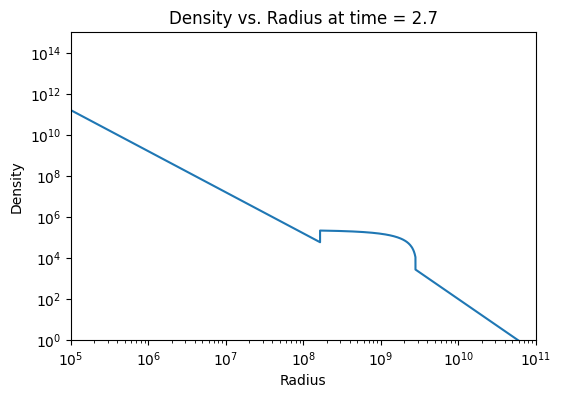

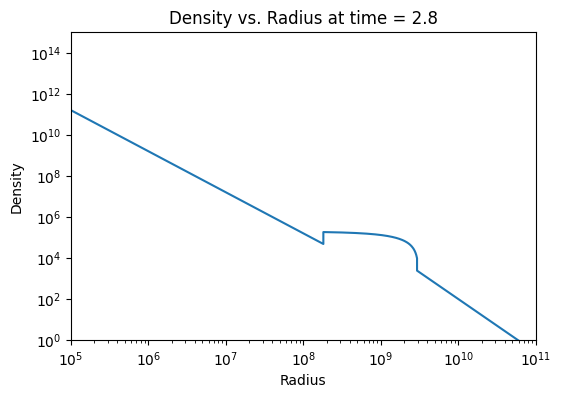

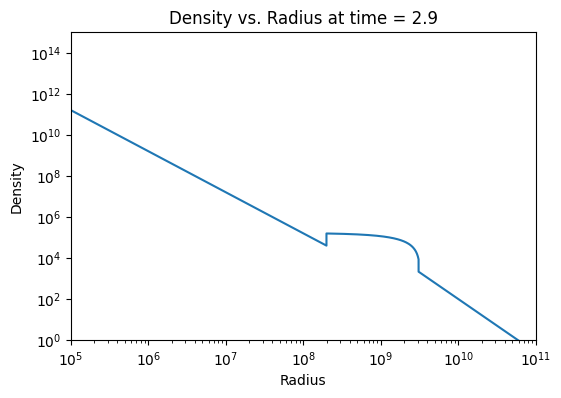

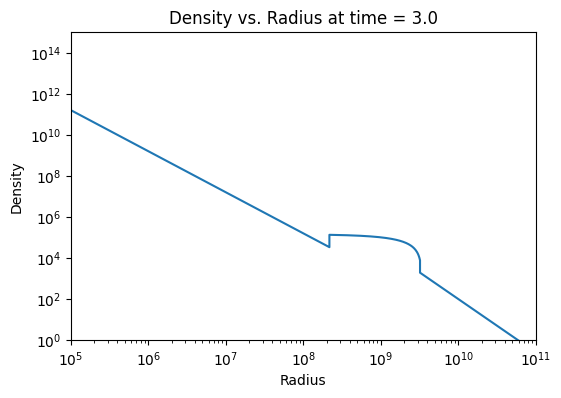

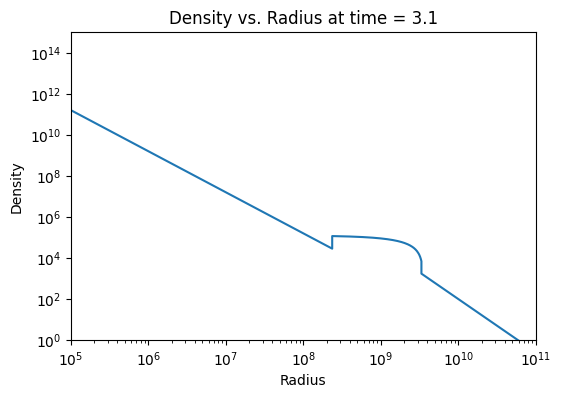

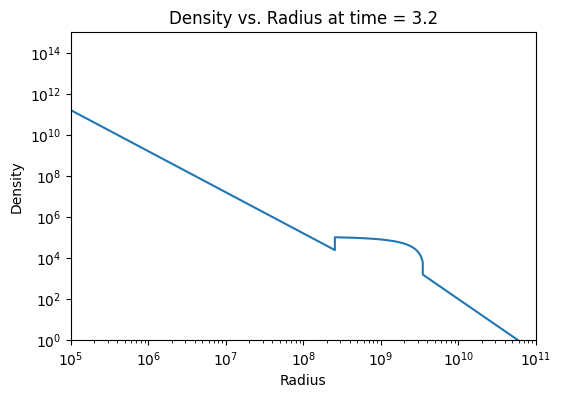

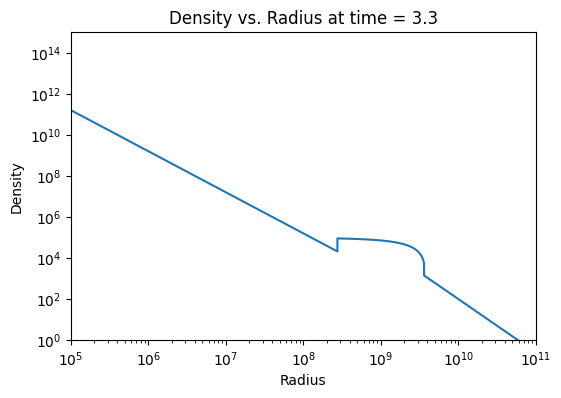

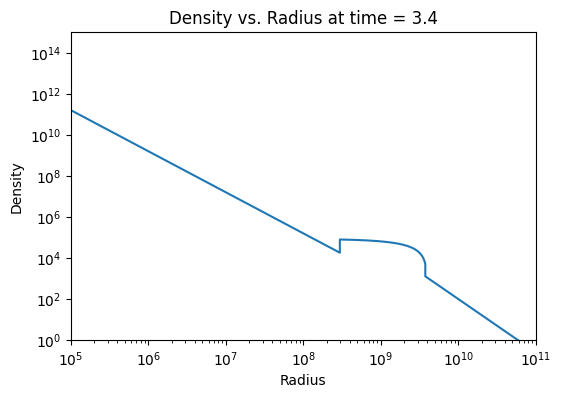

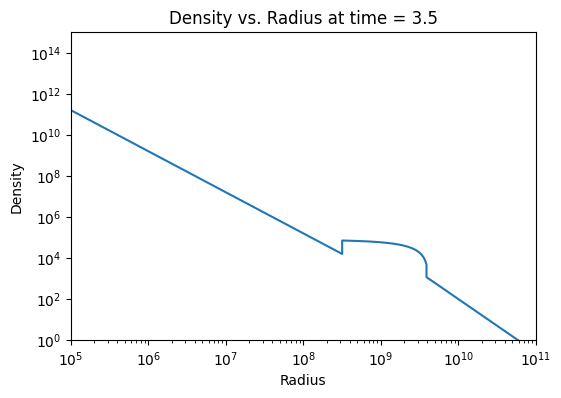

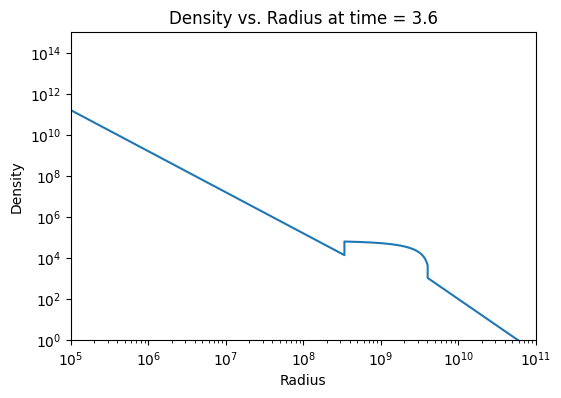

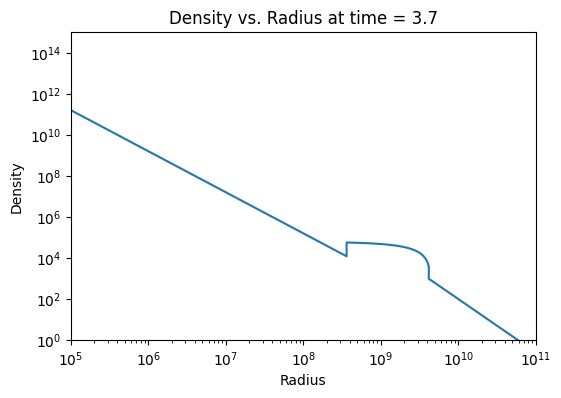

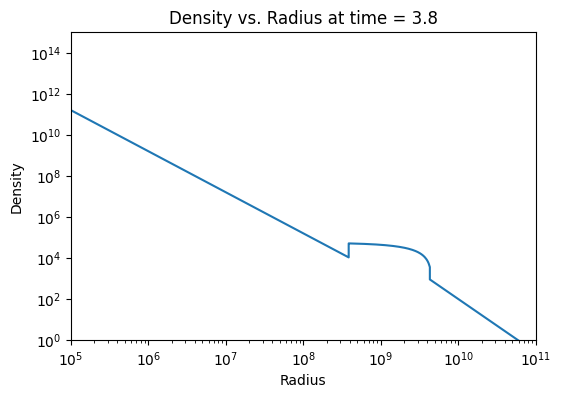

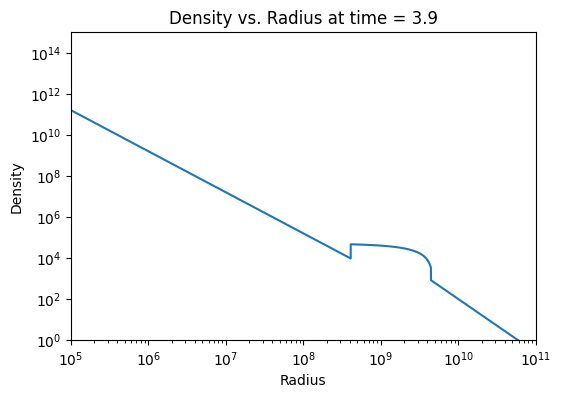

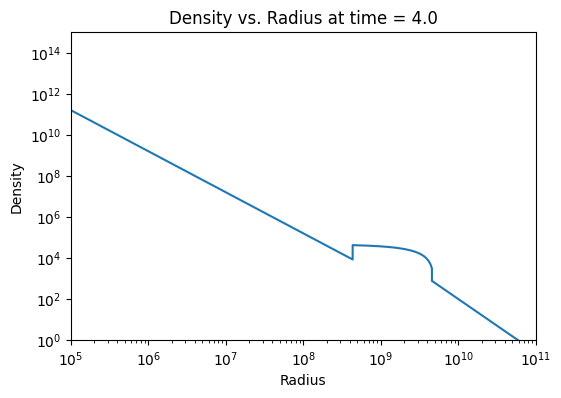

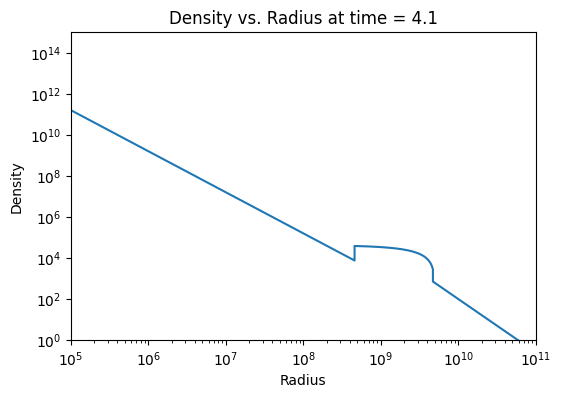

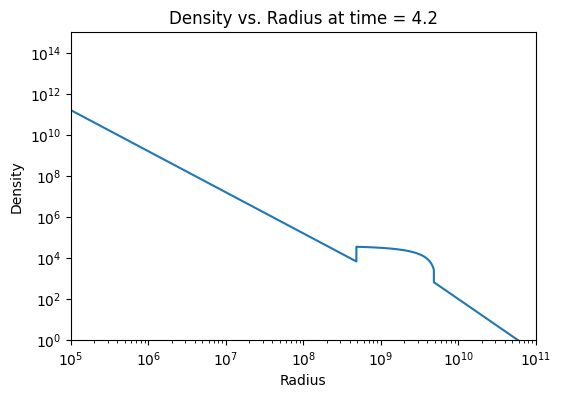

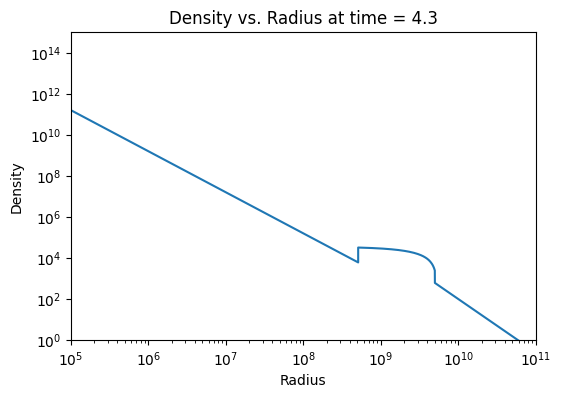

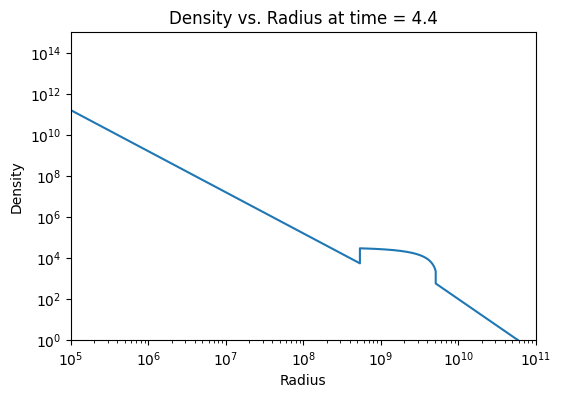

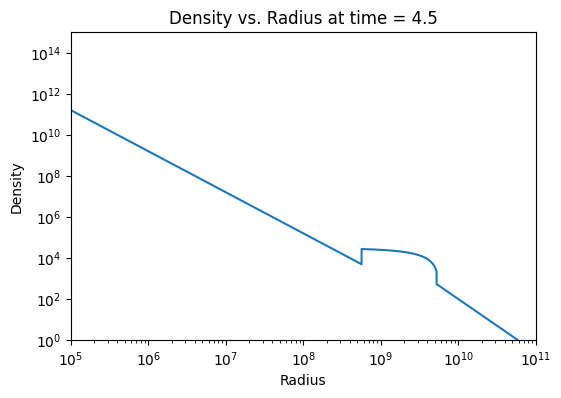

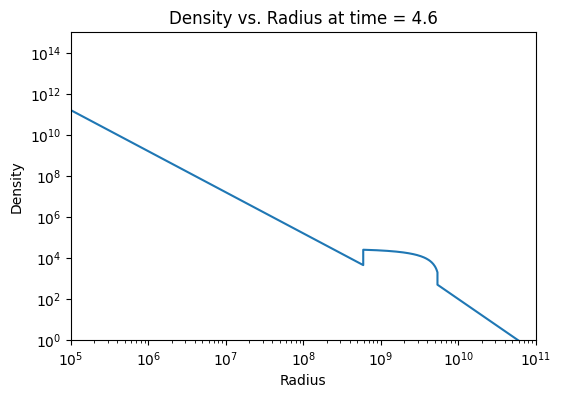

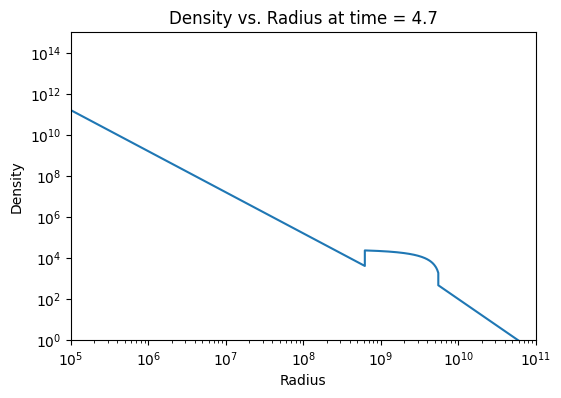

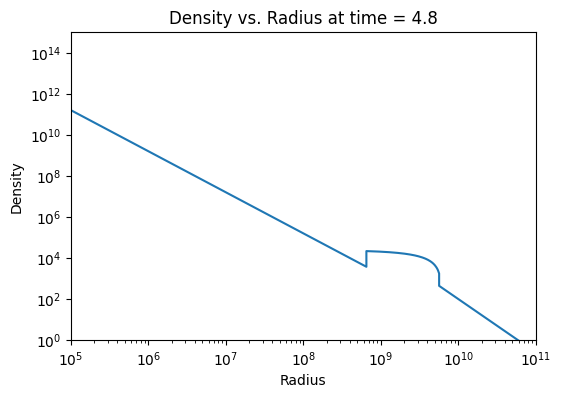

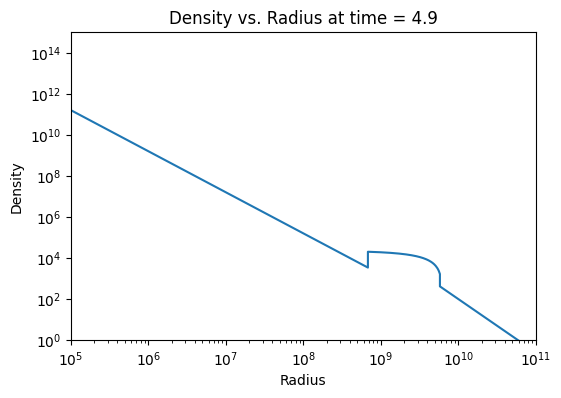

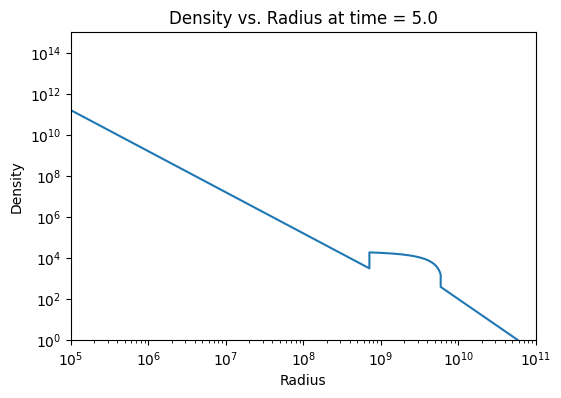

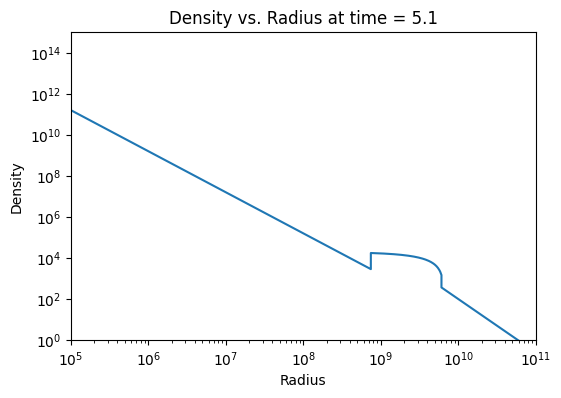

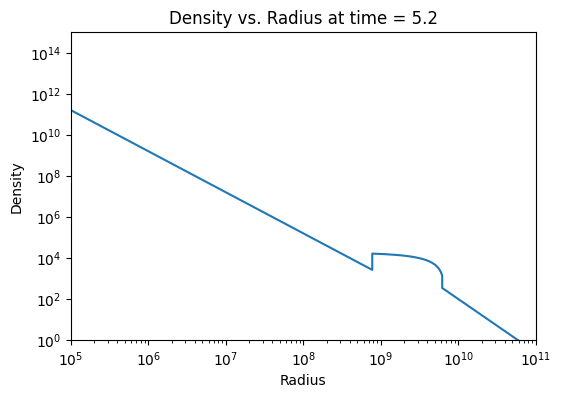

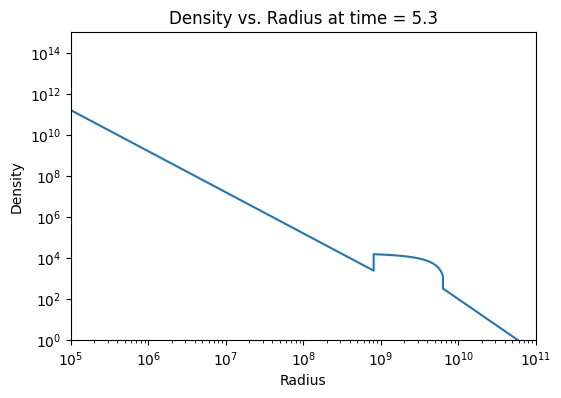

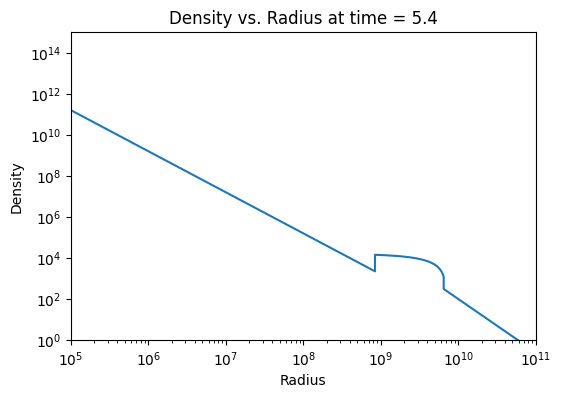

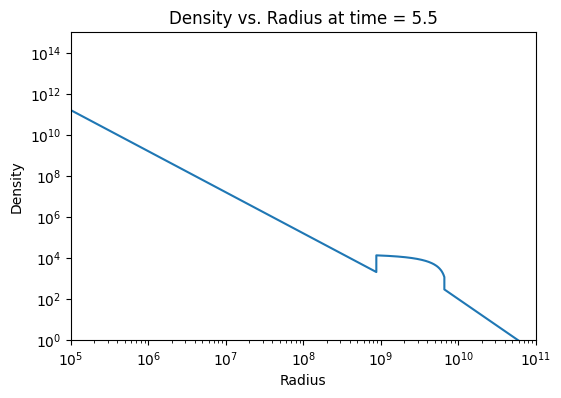

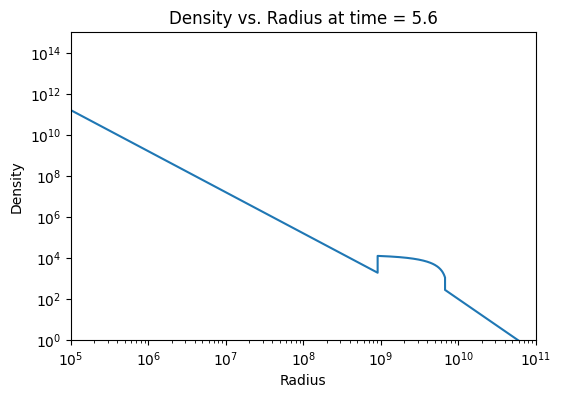

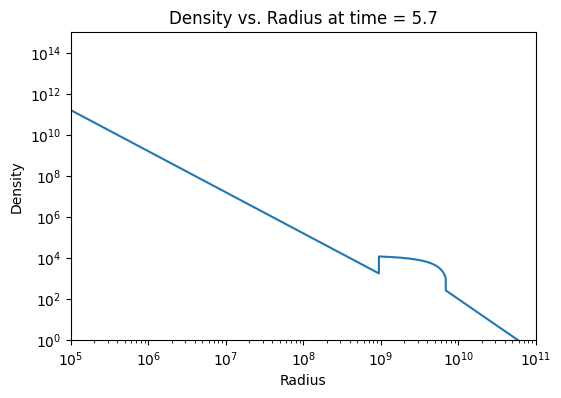

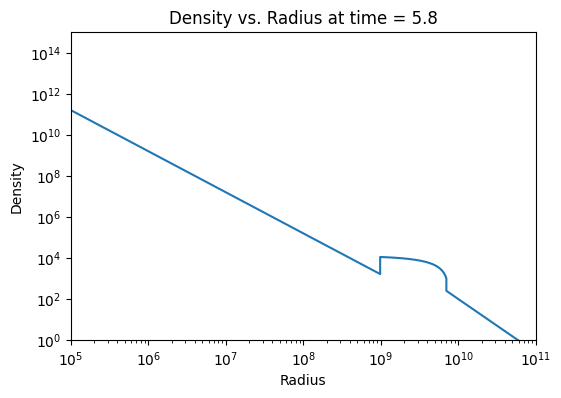

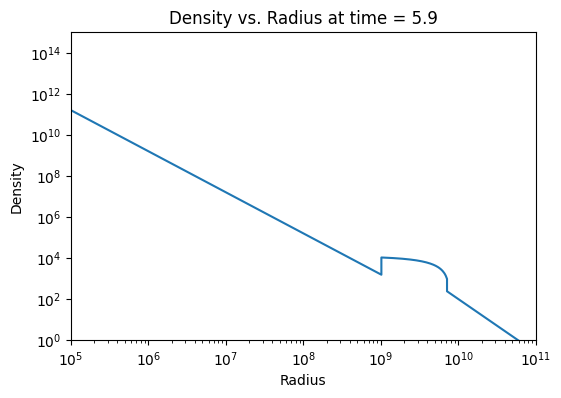

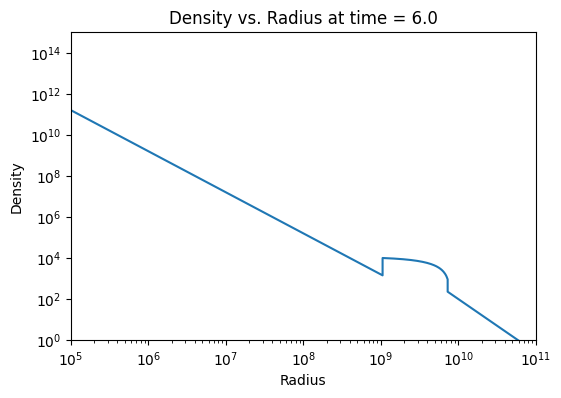

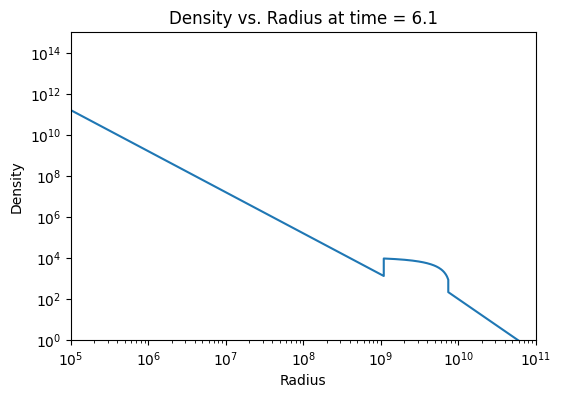

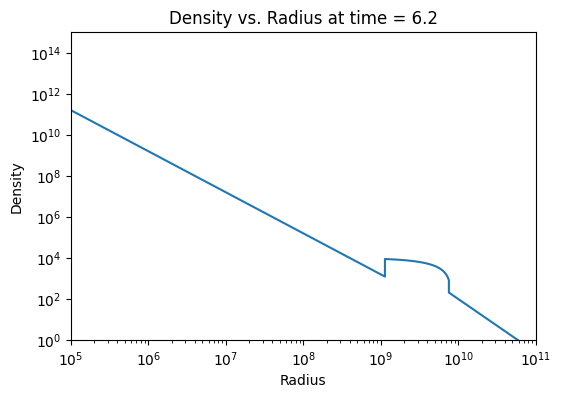

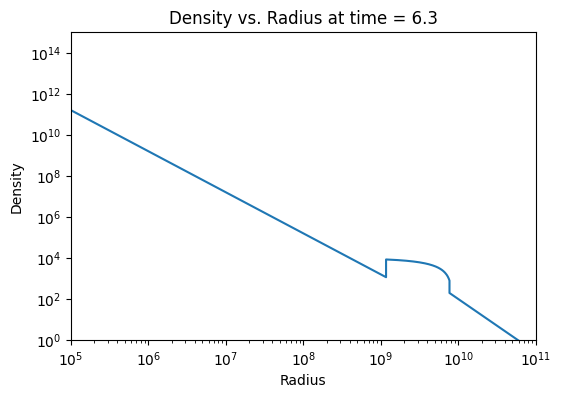

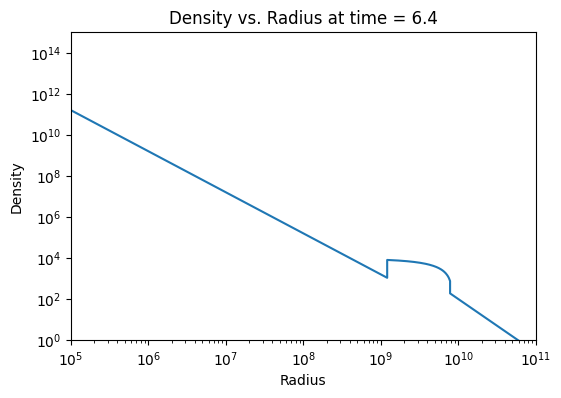

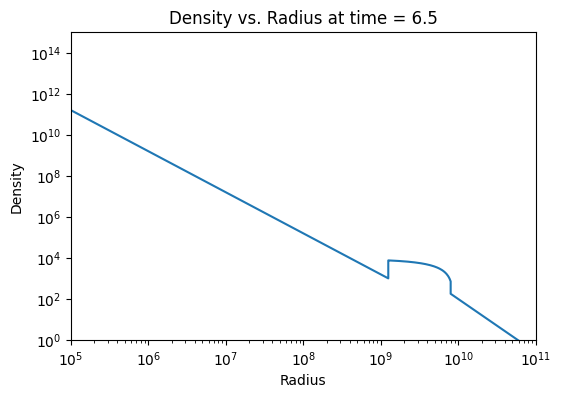

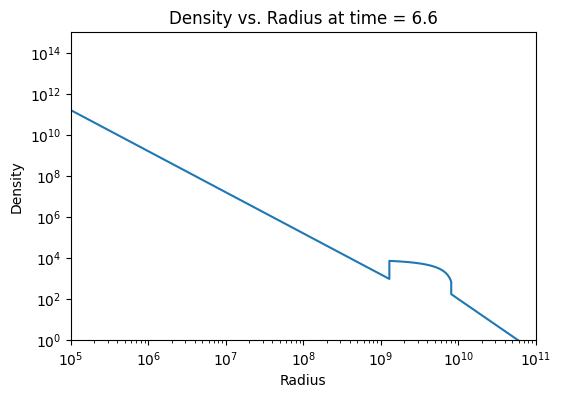

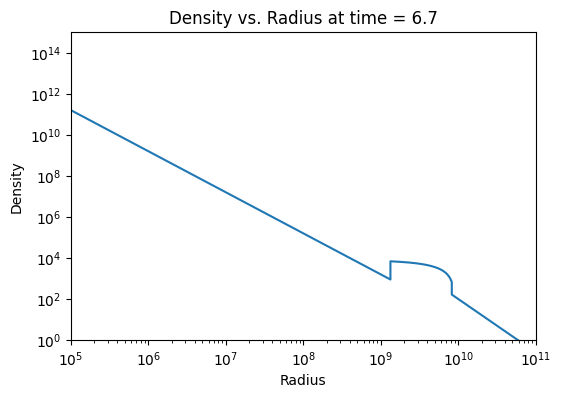

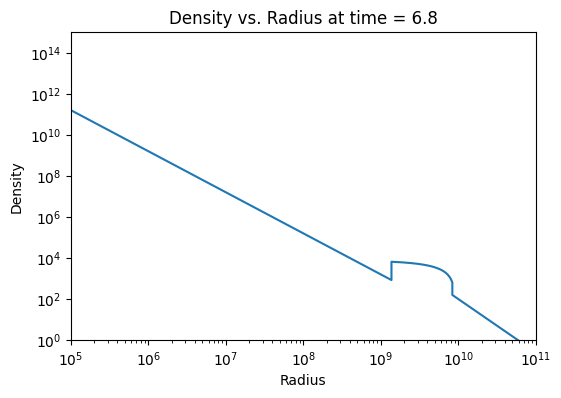

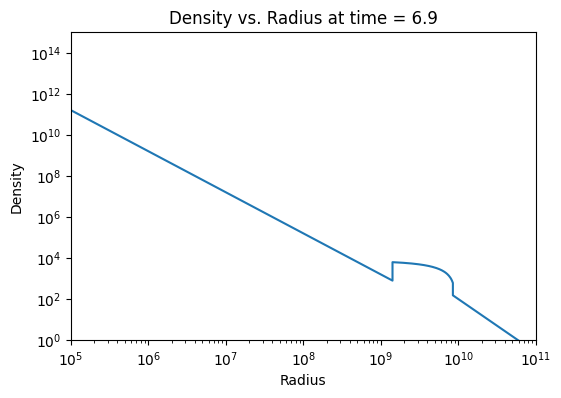

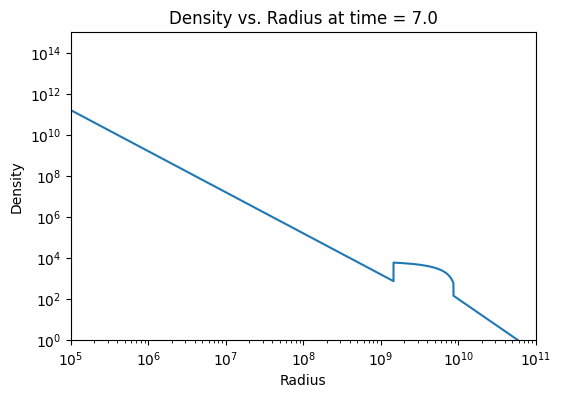

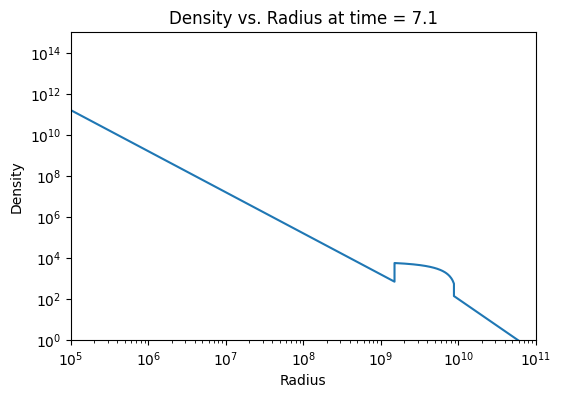

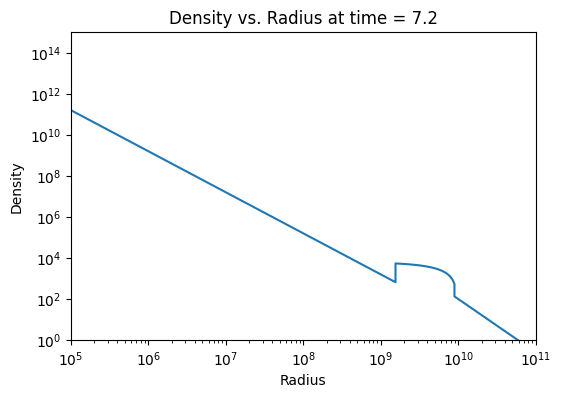

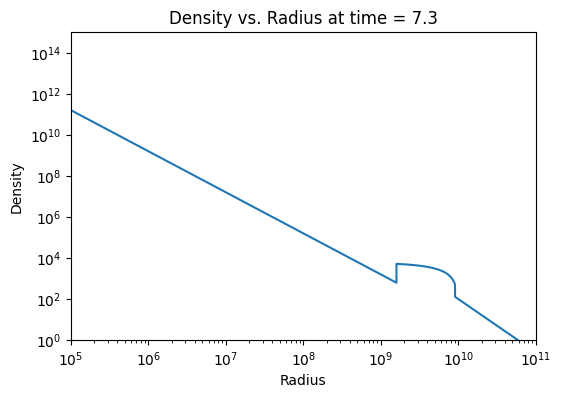

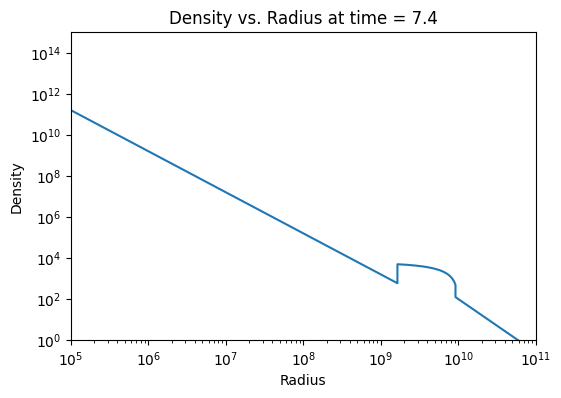

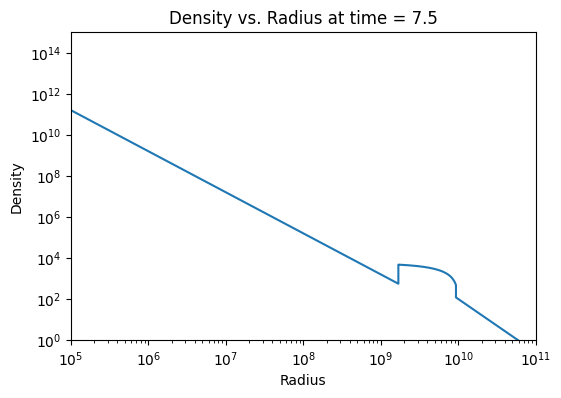

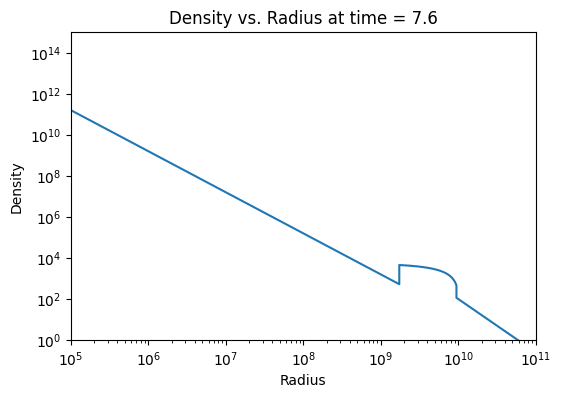

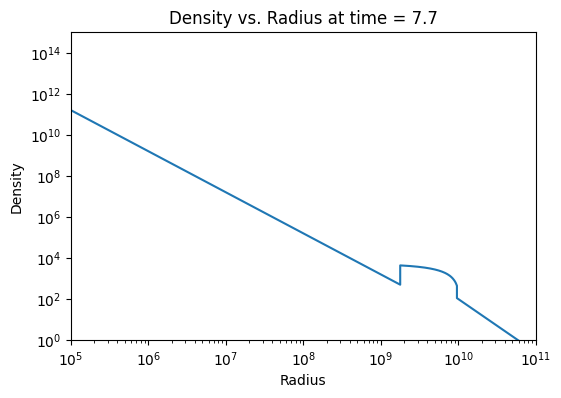

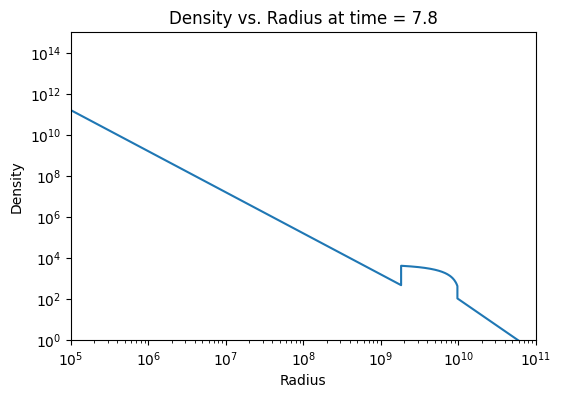

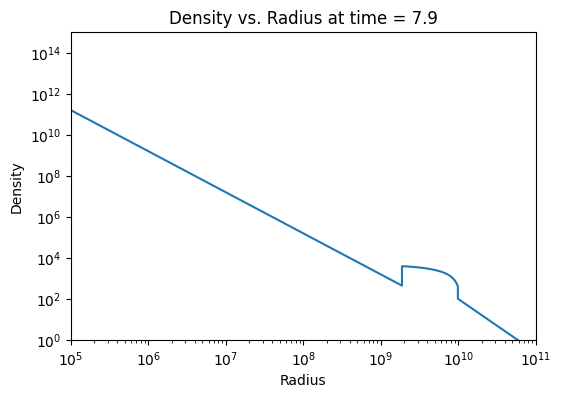

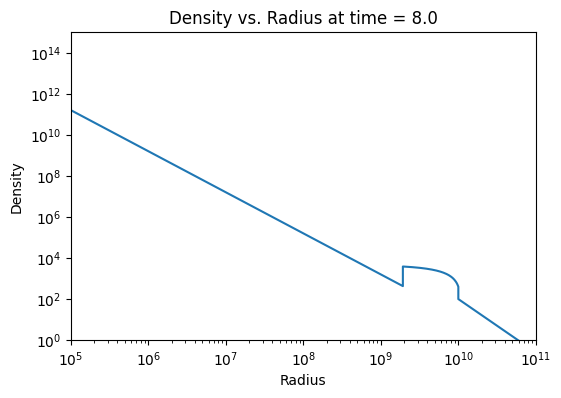

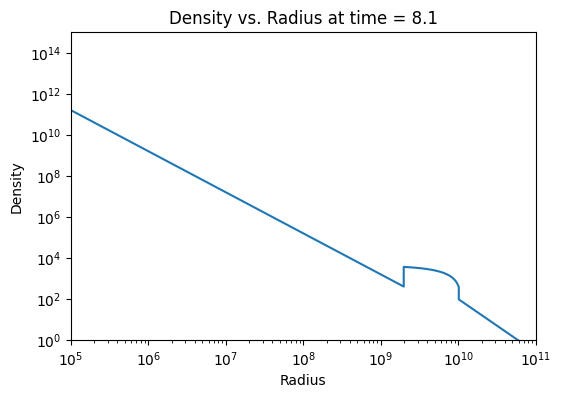

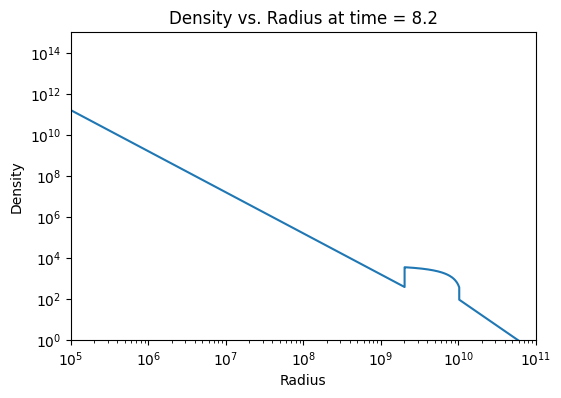

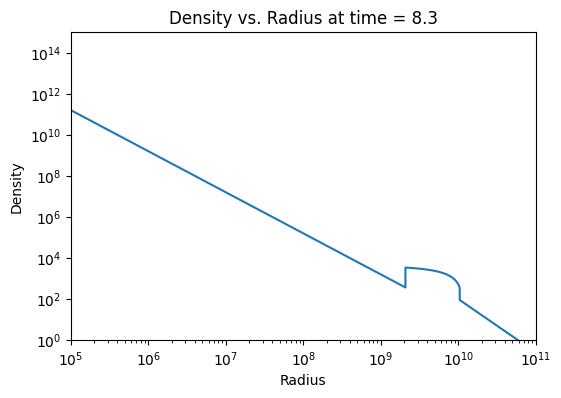

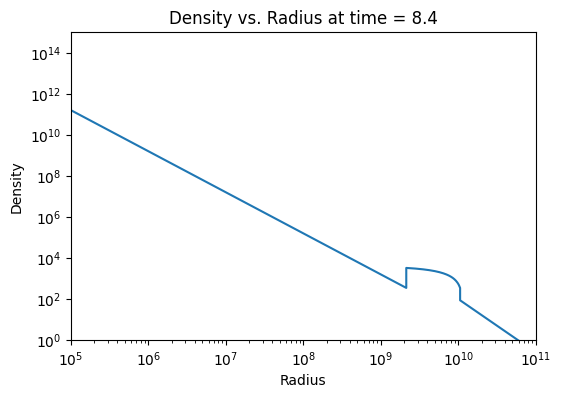

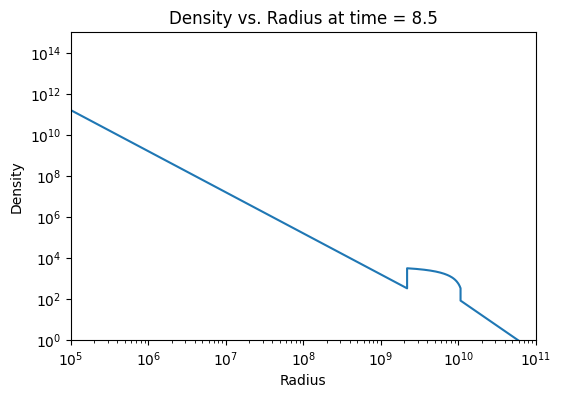

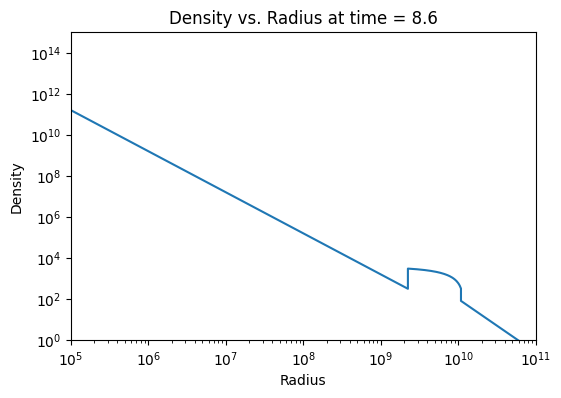

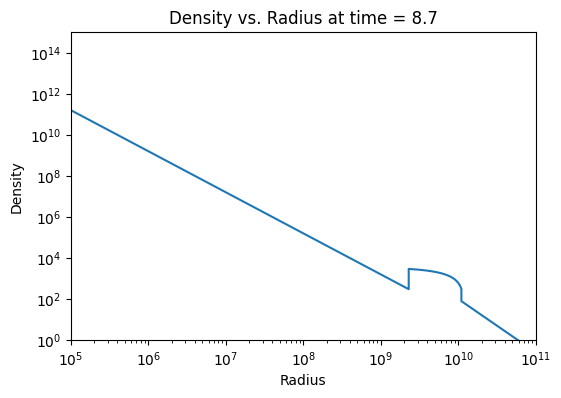

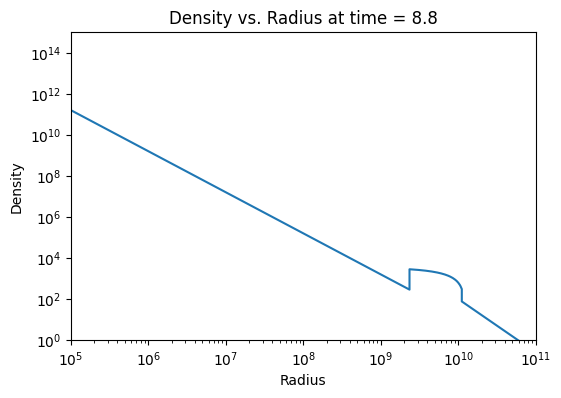

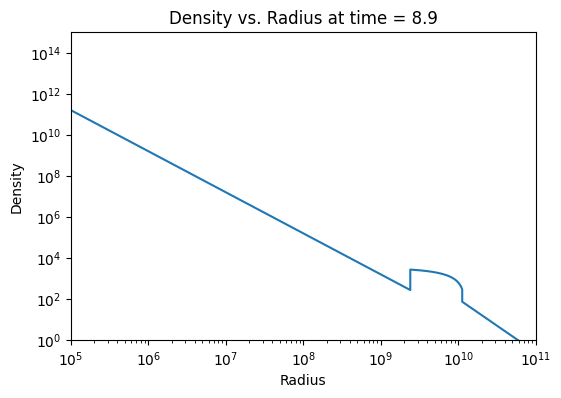

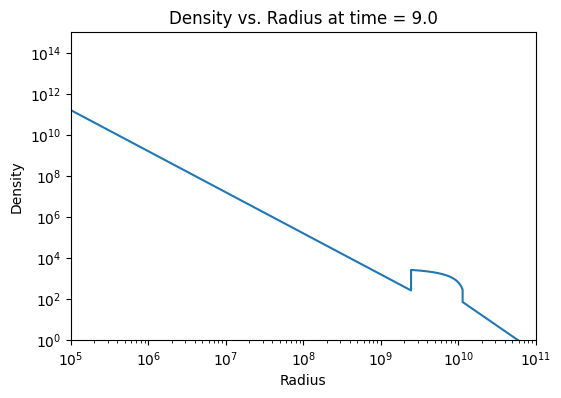

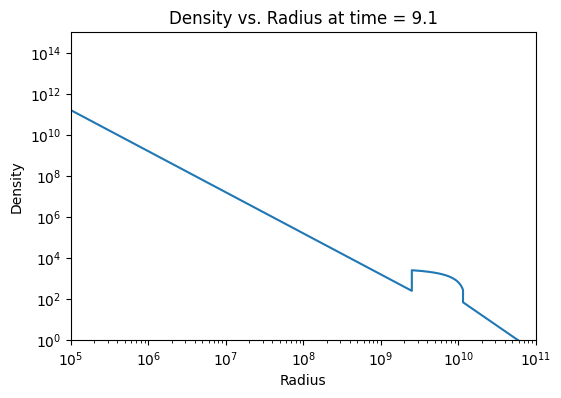

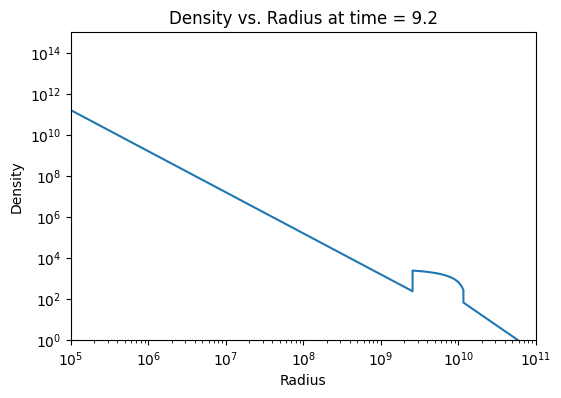

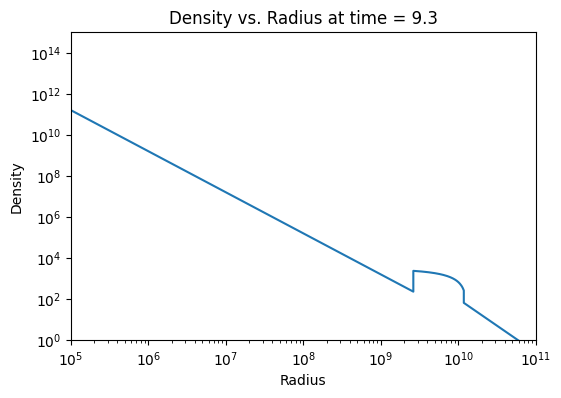

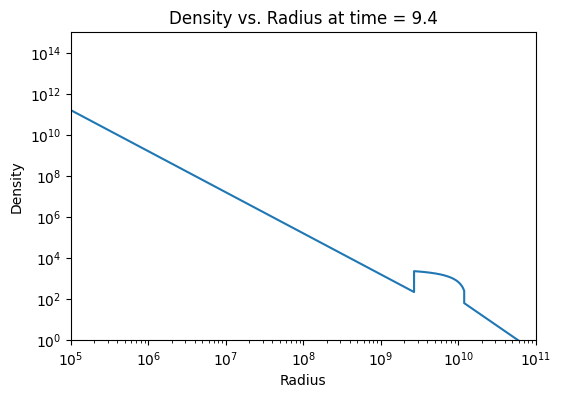

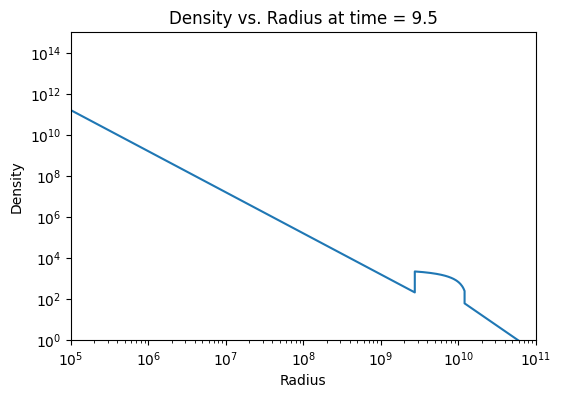

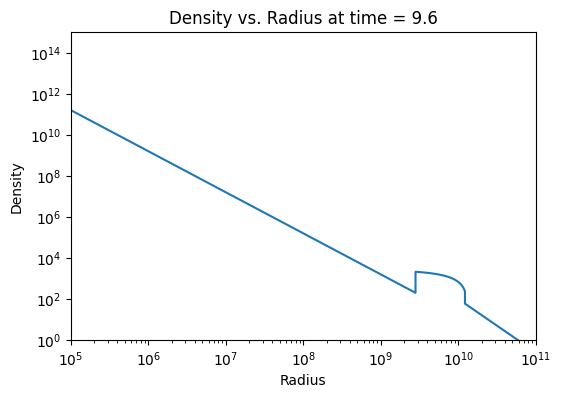

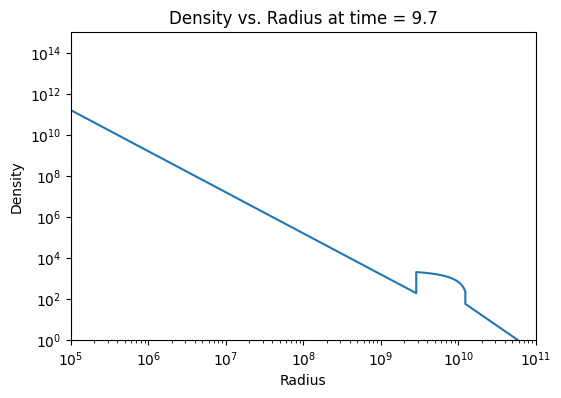

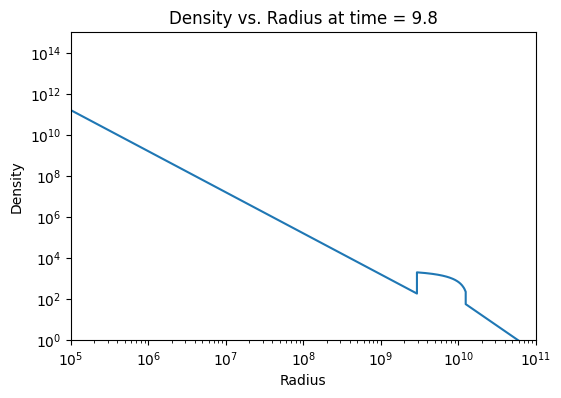

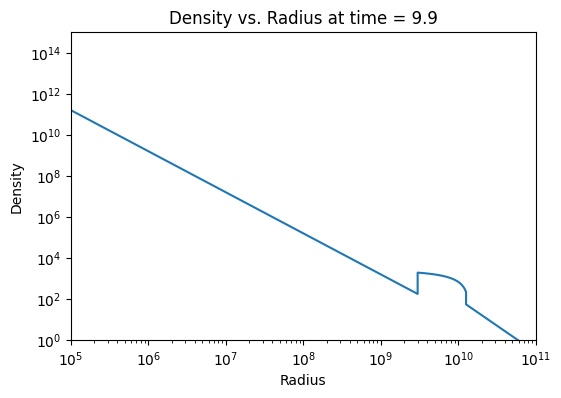

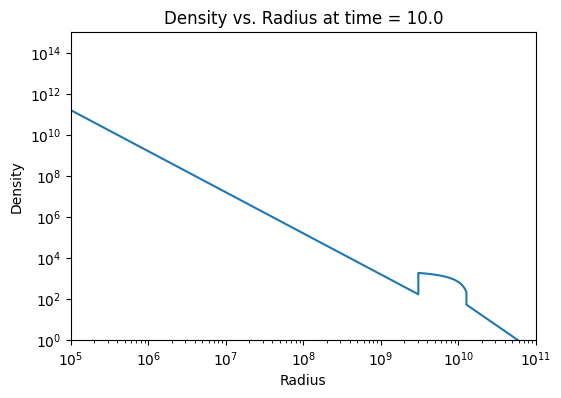

In [60]:
#generate the profiles

times = []

tmin = 0
tmax = 10
deltat = 0.1

Ntimes = (int)( (tmax - tmin) / deltat ) +1

for i in range(Ntimes):
    t = ( (int)( 10000*(i*deltat + tmin)) )/10000 # in seconds
    times.append(t)

    logr = np.linspace(5,11,600) 
    r = 10**(logr)

    data_radius = []
    data_density = []

    for j in range(len(r)-1):
        if r[j] < rRS(t) and r[j+1] < rRS(t):
            data_radius.append( r[j] )
            data_density.append( WindDensityProfile(r[j],t) )
        elif r[j] < rRS(t) and r[j+1] > rRS(t):
            data_radius.append( r[j] )
            data_density.append( WindDensityProfile(r[j],t) )
            data_radius.append( rRS(t) )
            data_density.append( WindDensityProfile(rRS(t),t) )
            data_radius.append( rRS(t) )
            data_density.append( InterShockDensityProfile(rRS(t),t) )
        elif r[j] > rRS(t) and r[j+1] < rFS(t):
            data_radius.append( r[j] )
            data_density.append( InterShockDensityProfile(r[j],t) )                               
        elif r[j] < rFS(t) and r[j+1] > rFS(t):
            data_radius.append( r[j] )
            data_density.append( InterShockDensityProfile(r[j],t) )
            data_radius.append( rFS(t) )
            data_density.append( InterShockDensityProfile(rFS(t),t) )
            data_radius.append( rFS(t) )
            data_density.append( ProgenitorDensityProfile(rFS(t)) )                                                            
        elif r[j] > rFS(t):
            data_radius.append( r[j] ) 
            data_density.append( ProgenitorDensityProfile(r[j]) ) 

    data_radius.append( r[-1] )
    data_density.append( ProgenitorDensityProfile(r[-1]) )
                                
    FileName = './profiles/profile_' + "{:05d}".format(i) + ".dat"        
    f = open(FileName, "w")

    for j in range(len(data_radius)):
        f.writelines([str(data_radius[j]) + "\t" + str(data_density[j]) + "\n"])
    f.close()

    plt.figure(figsize=(6,4))
    plt.plot(data_radius, data_density, '-')
    plt.xlabel('Radius')
    plt.ylabel('Density')
    
    plt.xscale('log')    
    plt.yscale('log')
    
    plt.xlim(left = 1e5, right = 1e11)
    plt.ylim(bottom = 1, top = 1e15)    

    plt.title('Density vs. Radius at time = ' + str(times[i]))
    FileName = './figures/profile_' + "{:05d}".format(i) + '.png'

    plt.savefig(FileName)
    plt.show()

In [61]:
#make the movie
import imageio

list_of_im_paths=[]
dirPath = './figures/profile_'

for i in range(len(times)):
    list_of_im_paths.append(dirPath + "{:05d}".format(i) + '.png')

ims = [imageio.imread(f) for f in list_of_im_paths]
imageio.mimwrite('./profile.gif', ims, duration = 50)

/tmp/ipykernel_1999455/2390163825.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ims = [imageio.imread(f) for f in list_of_im_paths]
